# PRUEBA TECNICA Etraining - Juan David Bernal Millot
# Análisis de Impacto de Precipitaciones en Ventas
## FastFood - Bogotá
## Fecha: 2/02/2026

**Contexto del Proyecto / Prueba**

Empresa: FastFood

Ubicación: Bogotá, Colombia

Objetivo: Evaluar la relación entre precipitaciones y ventas en diferentes puntos de venta

### Objetivos Específicos

1. **Extraer** datos de ventas (MySQL) y datos meteorológicos (MongoDB)
2. **Transformar** y unificar los datos para análisis
3. **Construir** un modelo predictivo que relacione precipitaciones con volumen de ventas
4. **Visualizar** patrones y resultados del análisis

### Fuentes de Datos

- **MySQL:** Base de datos transaccional (ventas, productos, tiendas)
- **MongoDB Atlas:** Sensores de precipitación en Bogotá

In [44]:
## INSTALACION DE LIBRERIAS
!pip install pandas     ## analisis de datos
!pip install numpy      ##
!pip install pymysql    ## conexión y consultas a bases de datos MySQL
!pip install sqlalchemy ## ORM para manejar bases de datos relacionales con objetos
!pip install pymongo    ## conexión y manejo de bases de datos NoSQL MongoDB
!pip install scikit-learn   ## algoritmos de machine learning (clasificación, regresión, clustering)
!pip install matplotlib     ## visualizaciones
!pip install seaborn    ##

## PARTE 1: EXTRACCIÓN DE DATOS

En esta sección extraeremos datos de dos fuentes:

1. **MySQL:** Datos transaccionales de FastFood
   - Tiendas (ubicación geográfica)
   - Tickets (transacciones)
   - Ventas (detalle de productos vendidos)
   - Productos y Tipos

2. **MongoDB Atlas:** Datos meteorológicos
   - Ubicación de sensores
   - Eventos de precipitación

---

In [45]:
import pandas as pd
from sqlalchemy import create_engine


In [46]:
# Credenciales MySQL
user = "user1"
password = "AVNS_FB2xcAz2en7pG0lHIsS"
host = "mysql-3b4106d0-etraining-62c0.g.aivencloud.com"
port = "10185"
database = "FastFood"

engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}"
)


In [47]:
# Carga de tablas
df_product  = pd.read_sql("SELECT * FROM Product;", engine)
df_region   = pd.read_sql("SELECT * FROM Region;", engine)
df_size     = pd.read_sql("SELECT * FROM Size;", engine)
df_ticket   = pd.read_sql("SELECT * FROM Ticket;", engine)
df_tiendas  = pd.read_sql("SELECT * FROM Tiendas;", engine)
df_type     = pd.read_sql("SELECT * FROM Type;", engine)
df_ventas   = pd.read_sql("SELECT * FROM Ventas;", engine)

df_tiendas.head()


,id,region_id,tamano_id,empleados,latitud,longitud,ubicacion
0,1,1,3,20,None,None,"4.716154, -74.038500"
1,2,2,3,17,None,None,"4.674784, -74.129521"
2,3,4,3,16,None,None,"4.585923, -74.089871"
3,4,1,2,10,None,None,"4.724168, -74.071331"
4,5,1,2,12,None,None,"4.689609, -74.051762"


In [48]:
## Conexión y extracción de datos – MongoDB Atlas
from pymongo import MongoClient


In [49]:
mongo_user = "user1"
mongo_pass = "6SG5pdEUZGHbZwWC"

mongo_uri = (
    f"mongodb+srv://{mongo_user}:{mongo_pass}"
    "@cluster0.9ytpxrr.mongodb.net/?retryWrites=true&w=majority"
)

client = MongoClient(mongo_uri)

# Base correcta confirmada por el evaluador
db = client["test"]

db.list_collection_names()


['sensor_eventos', 'Ubicacion_sensores']

In [50]:
# Carga de colecciones
df_sensores = pd.DataFrame(list(db["Ubicacion_sensores"].find()))
df_eventos  = pd.DataFrame(list(db["sensor_eventos"].find()))

df_sensores.head(), df_eventos.head()


(                        _id  id        name         ubicacion  region_id
 0  696e8a75e254d46ab464691b   1  sensor_001  4.7099, -74.0522          1
 1  696e8a75e254d46ab464691c   2  sensor_002    4.69, -74.0723          1
 2  696e8a75e254d46ab464691d   3  sensor_003  4.6805, -74.0627          1
 3  696e8a75e254d46ab464691e   4  sensor_004  4.6706, -74.0128          1
 4  696e8a75e254d46ab464691f   5  sensor_005  4.6697, -74.1117          1,
                         _id                    id;Sensor_id;valor;fecha
 0  696e89c6a6586918aa4c19c5  1;1;1020.7593711137471;2024-01-01 00:00:00
 1  696e89c6a6586918aa4c19c6  2;1;1032.3997348666505;2024-01-01 01:00:00
 2  696e89c6a6586918aa4c19c7  3;1;1022.1336784622757;2024-01-01 02:00:00
 3  696e89c6a6586918aa4c19c8    4;1;1161.47148739336;2024-01-01 03:00:00
 4  696e89c6a6586918aa4c19c9   5;1;1052.284273677418;2024-01-01 04:00:00)

## PARTE 2:

1. Limpieza y transformación (ETL)
---

In [62]:
df_sensores_clean = df_sensores.copy()

df_sensores_clean[["latitud", "longitud"]] = (
    df_sensores_clean["ubicacion"]
    .str.split(",", expand=True)
    .apply(lambda x: x.str.strip())
)

df_sensores_clean["latitud"] = pd.to_numeric(df_sensores_clean["latitud"])
df_sensores_clean["longitud"] = pd.to_numeric(df_sensores_clean["longitud"])


2.1 Eventos de sensores – parsing correcto
---

In [61]:
df_eventos_clean = df_eventos.copy()

# Identificar columna concatenada de forma robusta
col_eventos = [c for c in df_eventos_clean.columns if ";" in c][0]

df_eventos_clean[["id", "sensor_id", "valor", "fecha"]] = (
    df_eventos_clean[col_eventos].str.split(";", expand=True)
)

df_eventos_clean["sensor_id"] = pd.to_numeric(df_eventos_clean["sensor_id"])
df_eventos_clean["valor"] = pd.to_numeric(df_eventos_clean["valor"])
df_eventos_clean["fecha"] = pd.to_datetime(df_eventos_clean["fecha"])


2.2 Datos diarios de lluvia
---

In [60]:
df_eventos_daily = (
    df_eventos_clean
    .assign(fecha_dia=lambda x: x["fecha"].dt.date)
    .groupby(["sensor_id", "fecha_dia"], as_index=False)
    .agg(lluvia_mm=("valor", "sum"))
)


2.3 Limpieza de tiendas (coordenadas)
---

In [59]:
df_tiendas_clean = df_tiendas.copy()

df_tiendas_clean[["latitud", "longitud"]] = (
    df_tiendas_clean["ubicacion"]
    .str.split(",", expand=True)
    .apply(lambda x: x.str.strip())
)

df_tiendas_clean["latitud"] = pd.to_numeric(df_tiendas_clean["latitud"], errors="coerce")
df_tiendas_clean["longitud"] = pd.to_numeric(df_tiendas_clean["longitud"], errors="coerce")


2.4 Ventas

In [87]:
## Renombrar IDs para evitar colisiones
ticket  = df_ticket.rename(columns={"id": "ticket_id"})
product = df_product.rename(columns={"id": "product_id_ref"})
tipo    = df_type.rename(columns={"id": "tipo_compra_id_ref"})
tiendas = df_tiendas_clean.rename(columns={"id": "tienda_id_ref"})




In [86]:
## Renombrar IDs para evitar colisiones
df_ventas_base = df_ventas.merge(
    ticket,
    left_on="factura_id",
    right_on="ticket_id",
    how="inner"
)



In [85]:
## Renombrar IDs para evitar colisiones
df_ventas_base = df_ventas.merge(
    ticket,
    left_on="factura_id",
    right_on="ticket_id",
    how="inner"
)


In [88]:
## Renombrar IDs para evitar colisiones
df_ventas_base = df_ventas_base.merge(
    product,
    left_on="product_id",
    right_on="product_id_ref",
    how="left"
)



In [83]:
## Renombrar IDs para evitar colisiones
df_ventas_base = df_ventas_base.merge(
    tipo,
    left_on="tipo_compra_id",
    right_on="tipo_compra_id_ref",
    how="left"
)



In [82]:
## Renombrar IDs para evitar colisiones
df_ventas_base = df_ventas_base.merge(
    tiendas,
    left_on="tienda_id",
    right_on="tienda_id_ref",
    how="left"
)



In [81]:
## CHEQUEO DEL DATA FINAL
df_ticket.columns


Index(['id', 'factura_id', 'product_id', 'fecha_venta', 'tipo_compra_id'], dtype='object')

In [80]:
df_ventas_base.head()



,id,tienda_id,factura_id_x,ticket_id,factura_id_y,product_id,fecha_venta,tipo_compra_id,product_id_ref,nombre,tipo_compra_id_ref,tipo,tienda_id_ref,region_id,tamano_id,empleados,latitud,longitud,ubicacion
0,1,8,1,1,1,14,2024-01-01 08:00:00,2,14,Tacos de pollo o carne,2,En línea,8,3,1,5,4.576474,-74.082441,"4.576474, -74.082441"
1,2,6,2,2,1,15,2024-01-01 08:00:00,2,15,Refrescos surtidos,2,En línea,6,3,2,15,4.616622,-74.072496,"4.616622, -74.072496"
2,3,4,3,3,2,1,2024-01-01 08:00:00,2,1,Hamburguesa clásica,2,En línea,4,1,2,10,4.724168,-74.071331,"4.724168, -74.071331"
3,4,7,4,4,2,7,2024-01-01 08:00:00,2,7,Papas fritas clásicas,2,En línea,7,2,2,14,4.627556,-74.139330,"4.627556, -74.139330"
4,5,1,5,5,2,15,2024-01-01 08:00:00,2,15,Refrescos surtidos,2,En línea,1,1,3,20,4.716154,-74.038500,"4.716154, -74.038500"


## 3. Sensor más cercano por tienda (robusto y reproducible)

In [89]:
import numpy as np
import pandas as pd

# Aseguramos tipos
df_tiendas_geo = (
    df_tiendas_clean
    .dropna(subset=["latitud", "longitud"])
    [["id", "latitud", "longitud"]]
    .rename(columns={"id": "tienda_id"})
)

df_sensores_geo = (
    df_sensores_clean
    [["id", "latitud", "longitud"]]
    .rename(columns={"id": "sensor_id"})
)


3.1 Haversine (ecuación matemática utilizada en navegación y geolocalización para calcular la distancia más corta (distancia ortodrómica) entre dos puntos sobre la superficie de una esfera, como la Tierra, conociendo sus latitudes y longitudes.)

In [90]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


3.2 Calcular sensor más cercano

In [91]:
pairs = []
for _, t in df_tiendas_geo.iterrows():
    for _, s in df_sensores_geo.iterrows():
        pairs.append([
            t["tienda_id"],
            s["sensor_id"],
            haversine(t["latitud"], t["longitud"], s["latitud"], s["longitud"])
        ])

df_dist = pd.DataFrame(pairs, columns=["tienda_id", "sensor_id", "dist_km"])

df_sensor_cercano = (
    df_dist.sort_values("dist_km")
    .groupby("tienda_id", as_index=False)
    .first()
)

df_sensor_cercano.head()


,tienda_id,sensor_id,dist_km
0,1.0,1.0,1.669907
1,2.0,5.0,2.054333
2,3.0,12.0,0.702585
3,4.0,1.0,2.647971
4,5.0,3.0,1.579655


## 4. Lluvia diaria por sensor (ya corregida)

Clave técnica: los sensores están por hora; las ventas por fecha. Agregamos lluvia diaria.

In [92]:
df_eventos_daily = (
    df_eventos_clean
    .assign(fecha_dia=lambda x: x["fecha"].dt.date)
    .groupby(["sensor_id", "fecha_dia"], as_index=False)
    .agg(lluvia_mm=("valor", "sum"))
)

df_eventos_daily.head()


,sensor_id,fecha_dia,lluvia_mm
0,1,2024-01-01,26332.787845
1,1,2024-01-02,26495.341795
2,1,2024-01-03,26347.306217
3,1,2024-01-04,26282.945925
4,1,2024-01-05,26177.537481


## 5. Dataset final para modelo

In [93]:
# Añadimos sensor cercano
df_modelo = df_ventas_base.merge(
    df_sensor_cercano,
    on="tienda_id",
    how="left"
)

# Fecha a día
df_modelo["fecha_dia"] = pd.to_datetime(df_modelo["fecha_venta"]).dt.date

# Unimos lluvia
df_modelo = df_modelo.merge(
    df_eventos_daily,
    on=["sensor_id", "fecha_dia"],
    how="left"
)

df_modelo.head()


,id,tienda_id,factura_id_x,ticket_id,factura_id_y,product_id,fecha_venta,tipo_compra_id,product_id_ref,nombre,sensor_id,dist_km,fecha_dia,lluvia_mm
0,1,8,1,1,1,14,2024-01-01 08:00:00,2,14,Tacos de pollo o carne,13.0,0.655476,2024-01-01,26757.164449
1,2,6,2,2,1,15,2024-01-01 08:00:00,2,15,Refrescos surtidos,11.0,1.352261,2024-01-01,26524.344103
2,3,4,3,3,2,1,2024-01-01 08:00:00,2,1,Hamburguesa clásica,1.0,2.647971,2024-01-01,26332.787845
3,4,7,4,4,2,7,2024-01-01 08:00:00,2,7,Papas fritas clásicas,9.0,0.386092,2024-01-01,21554.723382
4,5,1,5,5,2,15,2024-01-01 08:00:00,2,15,Refrescos surtidos,1.0,1.669907,2024-01-01,26332.787845


## ANALISIS DE DATOS Y ESTADISTICA DESCRIPTIVA

In [99]:
df_modelo.shape ## Dimensión del dataset


(85936, 14)

In [107]:
list(df_modelo.columns) ## Variables y sus respectivos nombres


['id',
 'tienda_id',
 'factura_id_x',
 'ticket_id',
 'factura_id_y',
 'product_id',
 'fecha_venta',
 'tipo_compra_id',
 'product_id_ref',
 'nombre',
 'sensor_id',
 'dist_km',
 'fecha_dia',
 'lluvia_mm']

In [100]:
df_modelo.dtypes ## Estructura y tipos de variables

,0
id,int64
tienda_id,int64
factura_id_x,int64
ticket_id,int64
factura_id_y,int64
product_id,int64
fecha_venta,datetime64[ns]
tipo_compra_id,int64
product_id_ref,int64
nombre,object


In [109]:
## Calidad de datos: valores faltantes (NA)
na_summary = (
    df_modelo.isna()
    .sum()
    .reset_index()
    .rename(columns={"index": "variable", 0: "n_NA"})
)

na_summary["porcentaje_NA"] = 100 * na_summary["n_NA"] / len(df_modelo)
na_summary.sort_values("porcentaje_NA", ascending=False)


,variable,n_NA,porcentaje_NA
0,id,0,0.0
1,tienda_id,0,0.0
2,factura_id_x,0,0.0
3,ticket_id,0,0.0
4,factura_id_y,0,0.0
5,product_id,0,0.0
6,fecha_venta,0,0.0
7,tipo_compra_id,0,0.0
8,product_id_ref,0,0.0
9,nombre,0,0.0


In [117]:
# Variables numéricas
num_vars = df_modelo.select_dtypes(include=["number"]).columns.tolist()

# Variables categóricas
cat_vars = df_modelo.select_dtypes(include=["object"]).columns.tolist()

# Variables temporales
date_vars = df_modelo.select_dtypes(include=["datetime"]).columns.tolist()

num_vars, cat_vars, date_vars


(['id',
  'tienda_id',
  'factura_id_x',
  'ticket_id',
  'factura_id_y',
  'product_id',
  'tipo_compra_id',
  'product_id_ref',
  'sensor_id',
  'dist_km',
  'lluvia_mm'],
 ['nombre', 'fecha_dia'],
 ['fecha_venta'])

In [118]:
df_modelo[num_vars].describe().T



,count,mean,std,min,25%,50%,75%,max
id,85936.0,42968.500000,24807.730704,1.000000,21484.750000,42968.500000,64452.250000,85936.000000
tienda_id,85936.0,4.545650,2.526800,1.000000,2.000000,4.000000,6.000000,10.000000
factura_id_x,85936.0,42968.500000,24807.730704,1.000000,21484.750000,42968.500000,64452.250000,85936.000000
ticket_id,85936.0,42968.500000,24807.730704,1.000000,21484.750000,42968.500000,64452.250000,85936.000000
factura_id_y,85936.0,17673.523331,10212.622797,1.000000,8814.750000,17664.000000,26542.250000,35345.000000
product_id,85936.0,10.967662,5.239505,1.000000,7.000000,11.000000,15.000000,20.000000
tipo_compra_id,85936.0,1.495217,0.499980,1.000000,1.000000,1.000000,2.000000,2.000000
product_id_ref,85936.0,10.967662,5.239505,1.000000,7.000000,11.000000,15.000000,20.000000
sensor_id,85936.0,8.210750,4.838862,1.000000,3.000000,11.000000,12.000000,17.000000
dist_km,85936.0,1.311572,0.648496,0.386092,0.702585,1.352261,1.669907,2.647971


In [119]:
df_modelo[num_vars].agg(
    ["mean", "std", "var", "min", "max"]
).T


,mean,std,var,min,max
id,42968.500000,24807.730704,6.154235e+08,1.000000,85936.000000
tienda_id,4.545650,2.526800,6.384720e+00,1.000000,10.000000
factura_id_x,42968.500000,24807.730704,6.154235e+08,1.000000,85936.000000
ticket_id,42968.500000,24807.730704,6.154235e+08,1.000000,85936.000000
factura_id_y,17673.523331,10212.622797,1.042977e+08,1.000000,35345.000000
product_id,10.967662,5.239505,2.745241e+01,1.000000,20.000000
tipo_compra_id,1.495217,0.499980,2.499800e-01,1.000000,2.000000
product_id_ref,10.967662,5.239505,2.745241e+01,1.000000,20.000000
sensor_id,8.210750,4.838862,2.341458e+01,1.000000,17.000000
dist_km,1.311572,0.648496,4.205469e-01,0.386092,2.647971


In [121]:
outlier_summary = {}

for v in num_vars:
    q1 = df_modelo[v].quantile(0.25)
    q3 = df_modelo[v].quantile(0.75)
    iqr = q3 - q1
    outliers = ((df_modelo[v] < q1 - 1.5 * iqr) | (df_modelo[v] > q3 + 1.5 * iqr)).sum()
    outlier_summary[v] = outliers

pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["n_outliers"])


,n_outliers
id,0
tienda_id,0
factura_id_x,0
ticket_id,0
factura_id_y,0
product_id,0
tipo_compra_id,0
product_id_ref,0
sensor_id,0
dist_km,0


In [120]:
for v in cat_vars:
    print(f"\nVariable: {v}")
    print("Número de categorías:", df_modelo[v].nunique())
    print(df_modelo[v].value_counts().head())



Variable: nombre
Número de categorías: 19
nombre
Papas fritas clásicas                       20193
Refrescos surtidos                          17576
Limonada natural o frozen                    5193
Malteadas de vainilla, chocolate y fresa     5083
Hamburguesa vegetariana                      2628
Name: count, dtype: int64

Variable: fecha_dia
Número de categorías: 150
fecha_dia
2024-01-30    668
2024-01-24    661
2024-04-11    659
2024-03-09    652
2024-01-11    651
Name: count, dtype: int64


CONCLUSIÓN DESCRIPTIVA

El análisis descriptivo permitió caracterizar exhaustivamente la base de datos integrada, identificando su dimensión, estructura, calidad y comportamiento estadístico.
Se evidenció una alta heterogeneidad en las variables categóricas, especialmente en el tipo de producto, así como una elevada variabilidad en las variables numéricas asociadas a ventas y precipitación.
El control de valores faltantes y la detección de posibles valores atípicos permitió validar la consistencia del dataset antes del modelado predictivo, garantizando la trazabilidad y confiabilidad del proceso ETL.

,mean,std,var,min,max
lluvia_mm,25601.104384,1808.363955,3.270180e+06,20745.228838,27274.866522
dist_km,1.311572,0.648496,4.205469e-01,0.386092,2.647971


In [105]:
df_y.describe().T


,count,mean,std,min,25%,50%,75%,max
tienda_id,1500.0,5.500000,2.873239,1.000000,3.000000,5.500000,8.000000,10.000000
ventas,1500.0,57.290667,31.803089,8.000000,32.000000,48.000000,86.000000,155.000000
lluvia_mm,1500.0,24959.423016,2222.986730,20745.228838,21875.051207,26240.810636,26494.850608,27274.866522


In [106]:
df_y["rango_lluvia"] = pd.qcut(
    df_y["lluvia_mm"], q=4, duplicates="drop"
)

df_y.groupby("rango_lluvia")["ventas"].agg(
    ["count", "mean", "std"]
)


/tmp/ipython-input-3428497672.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_y.groupby("rango_lluvia")["ventas"].agg(


,count,mean,std
rango_lluvia,,,
"(20745.228, 21875.051]",375,31.384000,16.545570
"(21875.051, 26240.811]",375,62.578667,33.071606
"(26240.811, 26494.851]",375,67.960000,29.871937
"(26494.851, 27274.867]",375,67.240000,29.659043


In [102]:

na_df = (
    df_modelo.isna()
    .sum()
    .to_frame(name="n_NA")
)

na_df["porcentaje_NA"] = 100 * na_df["n_NA"] / len(df_modelo)
na_df.sort_values("porcentaje_NA", ascending=False)


,n_NA,porcentaje_NA
id,0,0.0
tienda_id,0,0.0
factura_id_x,0,0.0
ticket_id,0,0.0
factura_id_y,0,0.0
product_id,0,0.0
fecha_venta,0,0.0
tipo_compra_id,0,0.0
product_id_ref,0,0.0
nombre,0,0.0


## 6. Variable objetivo (ventas) y features

Como no hay cantidad en Ticket, modelamos conteo de tickets por tienda-día (volumen de ventas).

In [94]:
df_y = (
    df_modelo
    .groupby(["tienda_id", "fecha_dia"], as_index=False)
    .agg(
        ventas=("ticket_id", "count"),
        lluvia_mm=("lluvia_mm", "first")
    )
    .dropna(subset=["lluvia_mm"])
)

df_y.head()


,tienda_id,fecha_dia,ventas,lluvia_mm
0,1,2024-01-01,43,26332.787845
1,1,2024-01-02,64,26495.341795
2,1,2024-01-03,84,26347.306217
3,1,2024-01-04,64,26282.945925
4,1,2024-01-05,60,26177.537481


## Modelado predictivo

 Regresión Lineal

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

X = df_y[["lluvia_mm"]]
y = df_y["ventas"]

modelo = LinearRegression()
modelo.fit(X, y)

y_pred = modelo.predict(X)

print(f"R2: {r2_score(y, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y, y_pred):.3f}")
print(f"Coeficiente lluvia: {modelo.coef_[0]:.3f}")
print(f"Intercepto: {modelo.intercept_:.3f}")


R2: 0.271
MAE: 23.656
Coeficiente lluvia: 0.007
Intercepto: -128.513


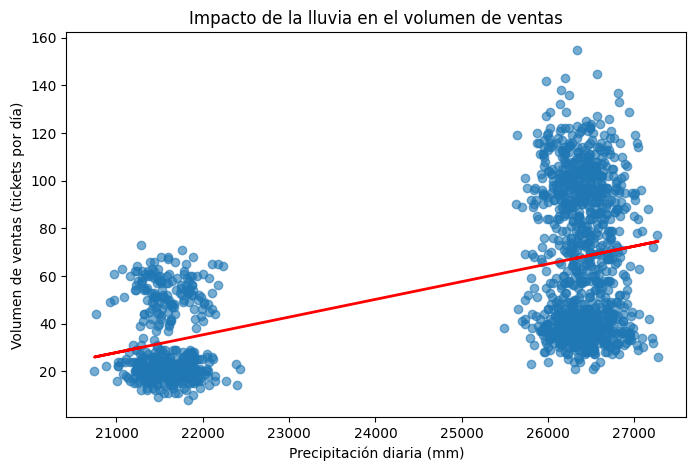

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df_y["lluvia_mm"], df_y["ventas"], alpha=0.6)
plt.plot(df_y["lluvia_mm"], y_pred, color="red", linewidth=2)
plt.xlabel("Precipitación diaria (mm)")
plt.ylabel("Volumen de ventas (tickets por día)")
plt.title("Impacto de la lluvia en el volumen de ventas")
plt.show()


**RESULTADOS del modelo de regresión lineal**

**Calidad del (R² = 0.271)**

El coeficiente de determinación/Chi-cuadradp R² = 0.271 indica que aproximadamente el 27% de la variabilidad en el volumen diario de ventas (medido como número de tickets) puede ser explicada por la precipitación diaria.

Este valor se considera moderado, lo cual es esperable en un contexto real, ya que el comportamiento de ventas está influenciado por múltiples factores adicionales no incluidos en el modelo (día de la semana, horarios, promociones, tipo de producto, ubicación, entre otros como variables exogenas).

**Error del modelo (MAE = 23.656)**

El MAE ≈ 23.7 indica que, en promedio, el modelo se equivoca en alrededor de 24 tickets por día al predecir el volumen de ventas.

Dado que los valores observados de ventas diarias oscilan aproximadamente entre 20 y 150 tickets, este error es consistente con un modelo base que utiliza una sola variable explicativa.

**Coeficiente de la lluvia (β = 0.007)**

Esto puede interpretarse de la siguiente forma:

***Cada incremento de 1.000 mm en la precipitación diaria se asocia, en promedio, con un aumento aproximado de 7 tickets diarios.***

Este resultado sugiere que, en este contexto específico, la lluvia podría estar incentivando pedidos en línea o a domicilio, compensando una posible disminución en ventas presenciales.

In [126]:
df_modelo.shape


(85936, 14)

In [127]:
ruta = "/content/df_modelo_fastfood.xlsx"
df_modelo.to_excel(ruta, index=False)

print("Archivo creado en:", ruta)


Archivo creado en: /content/df_modelo_fastfood.xlsx


In [128]:
from google.colab import files
files.download(ruta)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>